In [27]:
from tmm_ml_models import ReverseTMMModel, ForwardTMMModel
import pandas as pd
import matplotlib.pyplot as plt


curve = pd.read_csv("RecipeCurve.csv", names=["Wavelength", "Reflectance"], index_col="Wavelength")
curve = curve.transpose()
curve.index = [1]

In [28]:
reverse_model = ReverseTMMModel(serialised_model_path="./reverse_model_v1_FINAL/")
f_model = ForwardTMMModel(serialised_model_path="forward_model_v1_FINAL")

In [29]:
materials = reverse_model.predict(curve)
materials

# Save recipe as csv
materials.to_csv("recipe.csv", index=False)

1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 21ms/step


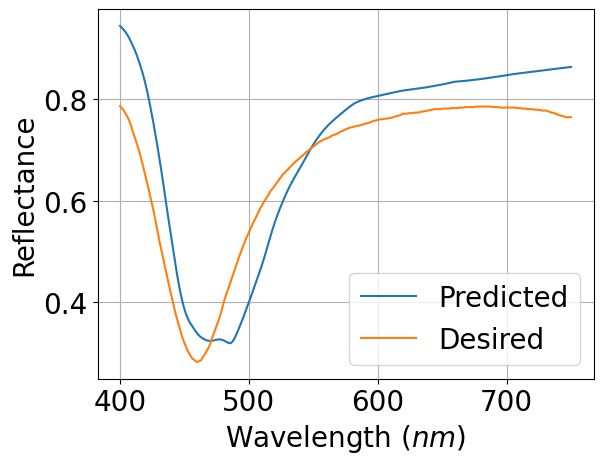

In [39]:
predicted_curve = f_model.predict(materials)

fig,ax = plt.subplots()

plt.rc("font", size=20)

plt.plot(predicted_curve.transpose(), label="Predicted")
plt.plot(curve.transpose(), label="Desired")

plt.xlabel("Wavelength ($nm$)")
plt.ylabel("Reflectance")
plt.grid(True)
plt.legend()


In [31]:
materials[["First Layer", "Second Layer"]]

,First Layer,Second Layer
1,Mo,MoO3


# Exploration of result

As an exploration of our result, the predicted waveform was compared to a similar line in the training data

In [32]:
training_data = pd.read_csv("R.csv")
combo = training_data.copy()[(training_data["First Layer"] == "Mo") & (training_data["Second Layer"] == "MoO3")]

In [33]:
t = ["d1", "d2", "d3", "d4", "d5", "d6"]

thicknesses = materials[t]
combo["score"] = (combo[t] - materials[t].squeeze()).sum(axis=1).apply(abs)
combo[combo["score"] == combo["score"].min()]

,d1,d2,d3,d4,d5,d6,First Layer,Second Layer,W400,W401,...,W742,W743,W744,W745,W746,W747,W748,W749,W750,score
3294,40,30,40,40,30,20,Mo,MoO3,0.937334,0.937739,...,0.949958,0.949954,0.949949,0.949945,0.949942,0.949938,0.949935,0.949932,0.949929,3.985526
6009,40,30,10,50,10,60,Mo,MoO3,0.934502,0.934315,...,0.949206,0.949204,0.949202,0.949201,0.949200,0.949200,0.949199,0.949199,0.949199,3.985526
14691,30,60,30,40,10,30,Mo,MoO3,0.921740,0.920718,...,0.941403,0.941414,0.941426,0.941437,0.941449,0.941460,0.941472,0.941484,0.941497,3.985526
19623,60,20,60,40,10,10,Mo,MoO3,0.947926,0.948057,...,0.952135,0.952128,0.952121,0.952114,0.952108,0.952102,0.952096,0.952091,0.952086,3.985526
26517,30,10,30,40,50,40,Mo,MoO3,0.939404,0.939731,...,0.949456,0.949451,0.949446,0.949441,0.949437,0.949433,0.949429,0.949426,0.949422,3.985526
29337,20,40,10,50,30,50,Mo,MoO3,0.874697,0.875887,...,0.926129,0.926162,0.926195,0.926228,0.926262,0.926295,0.926329,0.926363,0.926397,3.985526


In [34]:
materials[t]

,d1,d2,d3,d4,d5,d6
1,10.65939,61.539623,34.860306,32.441422,23.88052,32.633213


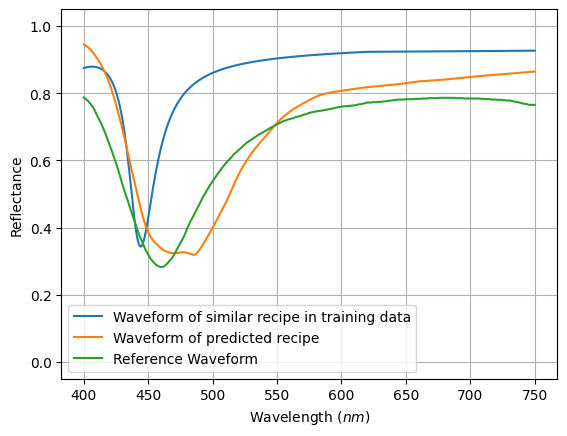

In [35]:
similar_waveform = combo.loc[29337][[c for c in combo.columns if c not in [*t, "First Layer", "Second Layer", "score"]]].copy()

similar_waveform.index = similar_waveform.index.map(lambda s: float(s[1:]))

fig,ax = plt.subplots()

ax.plot(similar_waveform, label="Waveform of similar recipe in training data")
ax.plot(predicted_curve.transpose(), label="Waveform of predicted recipe")
ax.plot(curve.transpose(), label="Reference Waveform")
ax.set_ylabel("Reflectance")
ax.set_xlabel("Wavelength ($nm$)")
ax.grid(True)
ax.set_ylim((-0.05, 1.05))

ax.legend()